# Evaluation using QCB chemicals (small)

This notebook uses the best DQN parameters optimised for 5E5 steps, but trained for 5E6 steps.
The results doesn't seem as good as the one optimised and trained for 5E5 steps.

In [ ]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys
from os.path import exists

sys.path.append('../..')

In [ ]:
import pylab as plt
import pandas as pd
import numpy as np
from loguru import logger
import seaborn as sns
import copy

from stable_baselines3 import DQN, PPO
from sb3_contrib import RecurrentPPO

In [ ]:
from vimms.Common import POSITIVE, set_log_level_warning, load_obj, save_obj
from vimms.ChemicalSamplers import UniformRTAndIntensitySampler, GaussianChromatogramSampler, UniformMZFormulaSampler, \
    MZMLFormulaSampler, MZMLRTandIntensitySampler, MZMLChromatogramSampler
from vimms.Noise import UniformSpikeNoise
from vimms.Evaluation import evaluate_real
from vimms.Chemicals import ChemicalMixtureFromMZML
from vimms.Roi import RoiBuilderParams, SmartRoiParams

from mass_spec_utils.data_import.mzmine import load_picked_boxes

from vimms_gym.env import DDAEnv
from vimms_gym.chemicals import generate_chemicals
from vimms_gym.evaluation import evaluate, run_method
from vimms_gym.common import METHOD_RANDOM, METHOD_FULLSCAN, METHOD_TOPN, METHOD_DQN, \
    METHOD_DQN_COV, METHOD_DQN_INT, METHOD_DQN_MID, METHOD_PPO, METHOD_PPO_RECURRENT

# 1. Parameters

Parameters that will be used throughout this notebook. Should be the same as the training ones.

Chemical generation parameters

In [ ]:
from experiments import preset_qcb_small
alpha = 0.50
beta = 0.10
extract = False
params, max_peaks = preset_qcb_small(None, alpha=alpha, beta=beta, extract_chromatograms=extract)
params, max_peaks

2022-08-30 09:08:19.940 | INFO     | experiments:get_samplers:244 - Loaded /notebooks/vimms-gym/pickles/samplers_QCB_small_gaussian.p


({'chemical_creator': {'mz_range': (100, 110),
   'rt_range': (400, 500),
   'intensity_range': (10000.0, 1e+20),
   'n_chemicals': (20, 50),
   'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7f33ae46a400>,
   'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7f33ae46a550>,
   'cr_sampler': <vimms.ChemicalSamplers.GaussianChromatogramSampler at 0x7f33a9dd0f10>},
  'noise': {'enable_spike_noise': True,
   'noise_density': 0.1,
   'noise_max_val': 1000.0,
   'mz_range': (100, 110)},
  'env': {'ionisation_mode': 'Positive',
   'rt_range': (400, 500),
   'isolation_window': 0.7,
   'mz_tol': 10,
   'rt_tol': 120,
   'alpha': 0.5,
   'beta': 0.1}},
 100)

In [ ]:
# n_chemicals = (20, 50)
# mz_range = (100, 110)
# rt_range = (400, 500)
# intensity_range = (1E4, 1E20)

Evaluation parameters

In [ ]:
env_name = 'DDAEnv'
intensity_threshold = 0.5
max_peaks = 100
in_dir = '../../tune/QCB_chems_small'
out_dir = 'evaluation_5.0E5'
methods = [
    METHOD_RANDOM,
    # METHOD_PPO,
    # METHOD_PPO_RECURRENT,
    METHOD_DQN,        
    METHOD_TOPN,
]
n_eval_episodes = 30

In [ ]:
# topN parameters
topN_N = 5
topN_rt_tol = 5
min_ms1_intensity = 5000

# smartroi parameters
alpha = 2
beta = 1
smartroi_N = topN_N
smartroi_dew = topN_rt_tol

# weighteddew parameters
t0 = 3
t1 = 120
weighteddew_N = 10

## Generate chemical sets for evaluation

In [ ]:
fname = 'QCB_chems_small.p'
found = exists(fname)
if found:
    chem_list = load_obj(fname)
    for chems in chem_list:
        print(len(chems))

28
22
45
28
20
38
34
21
37
45
36
46
49
24
32
42
25
34
44
37
23
40
43
37
27
32
34
26
28
34


Generate new chemicals if not found

In [ ]:
if not found:
    repeat = 30
    logger.warning('Generating chemicals')
    min_mz = mz_range[0]
    max_mz = mz_range[1]
    min_rt = rt_range[0]
    max_rt = rt_range[1]
    min_log_intensity = np.log(intensity_range[0])
    max_log_intensity = np.log(intensity_range[1])
    
    mzml_filename = '../fullscan_QCB.mzML'
    logger.info('Creating samplers from %s' % mzml_filename)
    mz_sampler = MZMLFormulaSampler(mzml_filename, min_mz=min_mz, max_mz=max_mz)
    ri_sampler = MZMLRTandIntensitySampler(mzml_filename, min_rt=min_rt, max_rt=max_rt,
                                           min_log_intensity=min_log_intensity,
                                           max_log_intensity=max_log_intensity)
    
    # roi_params = RoiBuilderParams(min_roi_length=3, at_least_one_point_above=1000)
    # cr_sampler = MZMLChromatogramSampler(mzml_filename, roi_params=roi_params)
    cr_sampler = GaussianChromatogramSampler()
    
    chemical_creator_params = {
        'mz_range': mz_range,
        'rt_range': rt_range,
        'intensity_range': intensity_range,
        'n_chemicals': n_chemicals,
        'mz_sampler': mz_sampler,
        'ri_sampler': ri_sampler,
        'cr_sampler': cr_sampler
    }

    chem_list = []
    for i in range(repeat):
        chems = generate_chemicals(chemical_creator_params)
        print(len(chems))
        chem_list.append(chems)
        
    save_obj(chem_list, fname)

In [ ]:
chem_list = chem_list[0:n_eval_episodes]
len(chem_list)

30

# 2. Evaluation

In [ ]:
set_log_level_warning()

1

In [ ]:
params

{'chemical_creator': {'mz_range': (100, 110),
  'rt_range': (400, 500),
  'intensity_range': (10000.0, 1e+20),
  'n_chemicals': (20, 50),
  'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7f33ae46a400>,
  'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7f33ae46a550>,
  'cr_sampler': <vimms.ChemicalSamplers.GaussianChromatogramSampler at 0x7f33a9dd0f10>},
 'noise': {'enable_spike_noise': True,
  'noise_density': 0.1,
  'noise_max_val': 1000.0,
  'mz_range': (100, 110)},
 'env': {'ionisation_mode': 'Positive',
  'rt_range': (400, 500),
  'isolation_window': 0.7,
  'mz_tol': 10,
  'rt_tol': 120,
  'alpha': 0.5,
  'beta': 0.1}}

In [ ]:
method_eval_results = {}
for method in methods:

    N = 0
    copy_params = copy.deepcopy(params)           
    custom_objects = {
        "learning_rate": 0.0,
        "lr_schedule": lambda _: 0.0,
        "clip_range": lambda _: 0.0,
    }    
    
    if method == METHOD_DQN:
        alpha = 0.50
        beta = 0.10
        model_dir = os.path.join(METHOD_DQN)
        fname = os.path.join(model_dir, '%s_%s.zip' % (env_name, method))
        model = DQN.load(fname, custom_objects=custom_objects)
        copy_params['env']['alpha'] = alpha
        copy_params['env']['beta'] = beta                
    elif method == METHOD_PPO:
        alpha = 0.50
        beta = 0.75
        model_dir = os.path.join(in_dir, 'metric_reward_timesteps_200000_alpha_%.2f_beta_%.2f' % (alpha, beta), METHOD_PPO)        
        fname = os.path.join(model_dir, 'best_model.zip')
        model = PPO.load(fname, custom_objects=custom_objects)
        copy_params['env']['alpha'] = alpha
        copy_params['env']['beta'] = beta                
    elif method == METHOD_PPO_RECURRENT:
        alpha = 0.50
        beta = 0.75
        model_dir = os.path.join(in_dir, 'metric_reward_timesteps_200000_alpha_%.2f_beta_%.2f' % (alpha, beta), METHOD_PPO_RECURRENT)        
        fname = os.path.join(model_dir, 'best_model.zip')        
        model = RecurrentPPO.load(fname, custom_objects=custom_objects)
        copy_params['env']['alpha'] = alpha
        copy_params['env']['beta'] = beta                
    else:
        model = None
        if method == METHOD_TOPN:
            N = topN_N
            effective_rt_tol = topN_rt_tol
            copy_params['env']['rt_tol'] = effective_rt_tol                        

    banner = 'method=%s max_peaks=%d N=%d rt_tol=%d alpha=%s beta=%s' % (
        method, max_peaks, N, copy_params['env']['rt_tol'], 
        str(copy_params['env']['alpha']), 
        str(copy_params['env']['beta']))
    print(banner)
    print()            
            
    episodic_results = run_method(env_name, copy_params, max_peaks, chem_list, method, out_dir, 
                                  N=N, min_ms1_intensity=min_ms1_intensity, model=model,
                                  print_eval=True, print_reward=True, intensity_threshold=intensity_threshold,
                                  mzml_prefix=method)
    eval_results = [er.eval_res for er in episodic_results]
    method_eval_results[method] = eval_results
    print()

method=random max_peaks=100 N=0 rt_tol=120 alpha=0.5 beta=0.1


Episode 0 (28 chemicals)
Finished after 493 timesteps with total reward -439.8559473112516
{'coverage_prop': '0.821', 'intensity_prop': '0.625', 'ms1ms2_ratio': '0.016', 'efficiency': '0.047', 'TP': '17', 'FP': '6', 'FN': '5', 'precision': '0.739', 'recall': '0.773', 'f1': '0.756', 'total_rewards': -439.8559473112514, 'invalid_action_count': 453}

Episode 1 (22 chemicals)
Finished after 496 timesteps with total reward -473.29067674520235
{'coverage_prop': '0.591', 'intensity_prop': '0.323', 'ms1ms2_ratio': '0.010', 'efficiency': '0.026', 'TP': '8', 'FP': '5', 'FN': '9', 'precision': '0.615', 'recall': '0.471', 'f1': '0.533', 'total_rewards': -473.29067674520235, 'invalid_action_count': 480}

Episode 2 (45 chemicals)
Finished after 492 timesteps with total reward -423.79299683054336
{'coverage_prop': '0.933', 'intensity_prop': '0.781', 'ms1ms2_ratio': '0.019', 'efficiency': '0.087', 'TP': '37', 'FP': '5', 'FN': '3', 'precis

#### Test classic controllers in ViMMS

In [ ]:
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import TopNController, TopN_SmartRoiController, WeightedDEWController
from vimms.Environment import Environment

Run Top-N Controller

In [ ]:
params

{'chemical_creator': {'mz_range': (100, 110),
  'rt_range': (400, 500),
  'intensity_range': (10000.0, 1e+20),
  'n_chemicals': (20, 50),
  'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7f33ae46a400>,
  'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7f33ae46a550>,
  'cr_sampler': <vimms.ChemicalSamplers.GaussianChromatogramSampler at 0x7f33a9dd0f10>},
 'noise': {'enable_spike_noise': True,
  'noise_density': 0.1,
  'noise_max_val': 1000.0,
  'mz_range': (100, 110)},
 'env': {'ionisation_mode': 'Positive',
  'rt_range': (400, 500),
  'isolation_window': 0.7,
  'mz_tol': 10,
  'rt_tol': 120,
  'alpha': 0.5,
  'beta': 0.1}}

In [ ]:
enable_spike_noise = params['noise']['enable_spike_noise']
ionisation_mode = params['env']['ionisation_mode']
isolation_window = params['env']['isolation_window']
mz_tol = params['env']['mz_tol']
rt_range = params['chemical_creator']['rt_range']

In [ ]:
method = 'TopN_Controller'
print('method = %s' % method)
print()

effective_rt_tol = topN_rt_tol
effective_N = topN_N
eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    controller = TopNController(ionisation_mode, effective_N, isolation_window, mz_tol, effective_rt_tol,
                                min_ms1_intensity)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()
    
method_eval_results[method] = eval_results

method = TopN_Controller

Episode 0 finished
{'coverage_prop': '0.929', 'intensity_prop': '0.836', 'ms1ms2_ratio': '1.504', 'efficiency': '0.208', 'TP': '23', 'FP': '3', 'FN': '2', 'precision': '0.885', 'recall': '0.920', 'f1': '0.902'}

Episode 1 finished
{'coverage_prop': '0.955', 'intensity_prop': '0.828', 'ms1ms2_ratio': '2.082', 'efficiency': '0.216', 'TP': '19', 'FP': '2', 'FN': '1', 'precision': '0.905', 'recall': '0.950', 'f1': '0.927'}

Episode 2 finished
{'coverage_prop': '1.000', 'intensity_prop': '0.859', 'ms1ms2_ratio': '1.159', 'efficiency': '0.298', 'TP': '39', 'FP': '6', 'FN': '0', 'precision': '0.867', 'recall': '1.000', 'f1': '0.929'}

Episode 3 finished
{'coverage_prop': '0.857', 'intensity_prop': '0.695', 'ms1ms2_ratio': '2.030', 'efficiency': '0.242', 'TP': '21', 'FP': '3', 'FN': '4', 'precision': '0.875', 'recall': '0.840', 'f1': '0.857'}

Episode 4 finished
{'coverage_prop': '1.000', 'intensity_prop': '0.799', 'ms1ms2_ratio': '2.194', 'efficiency': '0.215', 'TP':

Run SmartROI Controller

In [ ]:
method = 'SmartROI_Controller'
print('method = %s' % method)
print()

eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    
    roi_params = RoiBuilderParams(min_roi_intensity=0, min_roi_length=0)    
    smartroi_params = SmartRoiParams(intensity_increase_factor=alpha, drop_perc=beta/100.0)
    controller = TopN_SmartRoiController(ionisation_mode, isolation_window, smartroi_N, mz_tol, smartroi_dew,
                                min_ms1_intensity, roi_params, smartroi_params)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()    
    
method_eval_results[method] = eval_results

method = SmartROI_Controller

Episode 0 finished
{'coverage_prop': '0.929', 'intensity_prop': '0.808', 'ms1ms2_ratio': '4.612', 'efficiency': '0.531', 'TP': '22', 'FP': '4', 'FN': '2', 'precision': '0.846', 'recall': '0.917', 'f1': '0.880'}

Episode 1 finished
{'coverage_prop': '0.955', 'intensity_prop': '0.752', 'ms1ms2_ratio': '5.923', 'efficiency': '0.538', 'TP': '15', 'FP': '6', 'FN': '1', 'precision': '0.714', 'recall': '0.938', 'f1': '0.811'}

Episode 2 finished
{'coverage_prop': '0.978', 'intensity_prop': '0.825', 'ms1ms2_ratio': '2.892', 'efficiency': '0.595', 'TP': '37', 'FP': '7', 'FN': '1', 'precision': '0.841', 'recall': '0.974', 'f1': '0.902'}

Episode 3 finished
{'coverage_prop': '0.821', 'intensity_prop': '0.632', 'ms1ms2_ratio': '5.610', 'efficiency': '0.561', 'TP': '17', 'FP': '6', 'FN': '5', 'precision': '0.739', 'recall': '0.773', 'f1': '0.756'}

Episode 4 finished
{'coverage_prop': '0.850', 'intensity_prop': '0.730', 'ms1ms2_ratio': '6.105', 'efficiency': '0.447', '

Run WeightedDEW Controller

In [ ]:
method = 'WeightedDEW_Controller'
print('method = %s' % method)
print()

eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    
    controller = WeightedDEWController(ionisation_mode, weighteddew_N, isolation_window, mz_tol, t1,
                                min_ms1_intensity, exclusion_t_0=t0)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()    
    
method_eval_results[method] = eval_results

method = WeightedDEW_Controller

Episode 0 finished
{'coverage_prop': '0.929', 'intensity_prop': '0.846', 'ms1ms2_ratio': '0.854', 'efficiency': '0.141', 'TP': '23', 'FP': '3', 'FN': '2', 'precision': '0.885', 'recall': '0.920', 'f1': '0.902'}

Episode 1 finished
{'coverage_prop': '0.955', 'intensity_prop': '0.826', 'ms1ms2_ratio': '1.252', 'efficiency': '0.147', 'TP': '19', 'FP': '2', 'FN': '1', 'precision': '0.905', 'recall': '0.950', 'f1': '0.927'}

Episode 2 finished
{'coverage_prop': '1.000', 'intensity_prop': '0.854', 'ms1ms2_ratio': '0.772', 'efficiency': '0.228', 'TP': '38', 'FP': '7', 'FN': '0', 'precision': '0.844', 'recall': '1.000', 'f1': '0.916'}

Episode 3 finished
{'coverage_prop': '0.893', 'intensity_prop': '0.702', 'ms1ms2_ratio': '1.277', 'efficiency': '0.177', 'TP': '20', 'FP': '5', 'FN': '3', 'precision': '0.800', 'recall': '0.870', 'f1': '0.833'}

Episode 4 finished
{'coverage_prop': '1.000', 'intensity_prop': '0.806', 'ms1ms2_ratio': '1.252', 'efficiency': '0.140'

#### Plotting

Flatten data into dataframe

In [ ]:
data = []
for method in method_eval_results:
    eval_results = method_eval_results[method]
    for eval_res in eval_results:
        try:
            total_rewards = float(eval_res['total_rewards'])       
        except KeyError:
            total_rewards = 0.0

        try:
            invalid_action_count = float(eval_res['invalid_action_count'])       
        except KeyError:
            invalid_action_count = 0.0

        row = (
            method, 
            total_rewards, 
            invalid_action_count,
            float(eval_res['coverage_prop']), 
            float(eval_res['intensity_prop']), 
            float(eval_res['ms1ms2_ratio']), 
            float(eval_res['efficiency']),
            float(eval_res['precision']),
            float(eval_res['recall']),
            float(eval_res['f1']),            
        )
        data.append(row)
        
df = pd.DataFrame(data, columns=['method', 'total_rewards', 'invalid_action_count', 
    'coverage_prop', 'intensity_prop', 'ms1/ms2_ratio', 'efficiency', 
    'precision', 'recall', 'f1'])
# df.set_index('method', inplace=True)
df.head()

,method,total_rewards,invalid_action_count,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
0,random,-439.855947,453.0,0.821,0.625,0.016,0.047,0.739,0.773,0.756
1,random,-473.290677,480.0,0.591,0.323,0.010,0.026,0.615,0.471,0.533
2,random,-423.792997,442.0,0.933,0.781,0.019,0.087,0.881,0.925,0.902
3,random,-472.639714,480.0,0.679,0.435,0.008,0.039,0.684,0.591,0.634
4,random,-453.481207,461.0,0.800,0.503,0.021,0.033,0.500,0.667,0.571


In [ ]:
sns.set_context("poster")

Text(0.5, 1.0, 'Total Rewards')

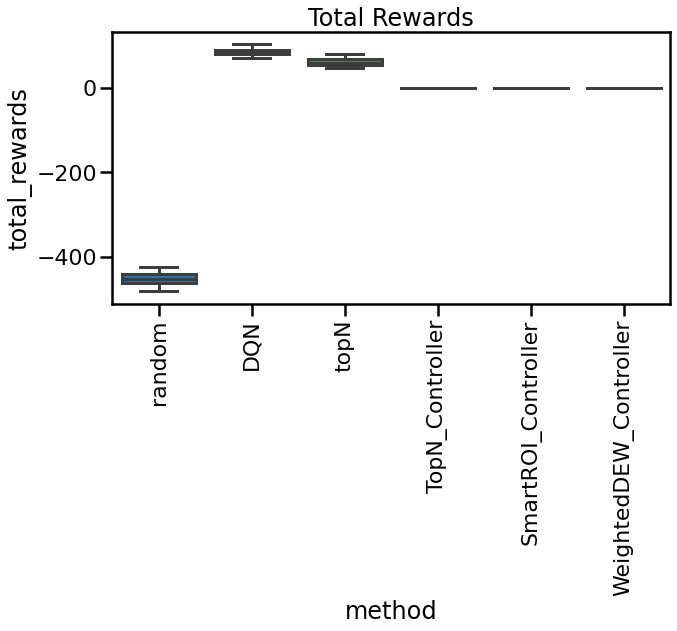

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='total_rewards')
plt.xticks(rotation=90)
plt.title('Total Rewards')

Text(0.5, 1.0, 'Invalid Action Count')

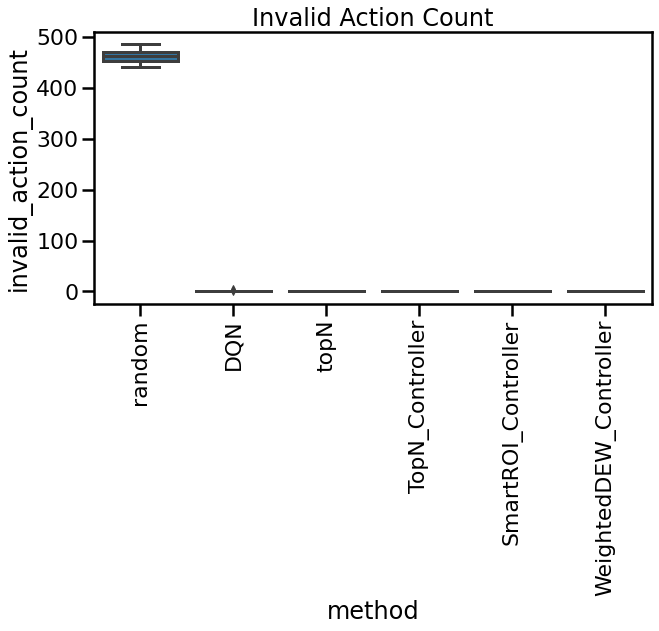

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='invalid_action_count')
plt.xticks(rotation=90)
plt.title('Invalid Action Count')

Text(0.5, 1.0, 'Coverage Proportion')

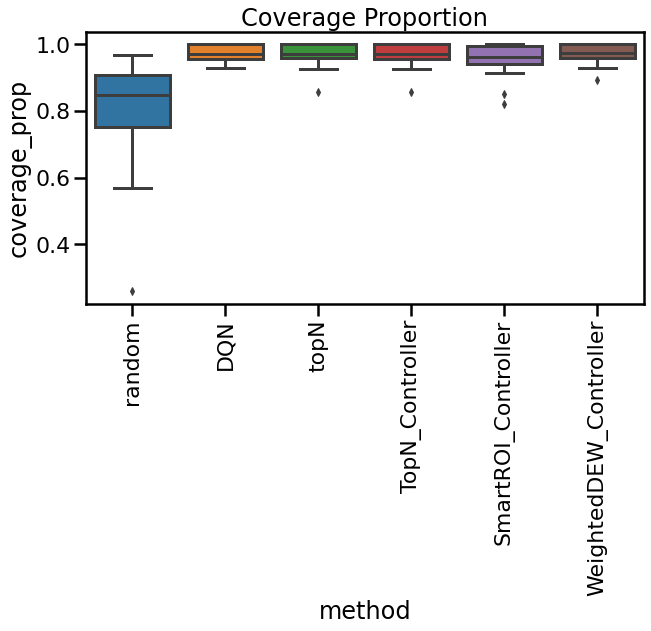

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='coverage_prop')
plt.xticks(rotation=90)
plt.title('Coverage Proportion')

Text(0.5, 1.0, 'Intensity Proportion')

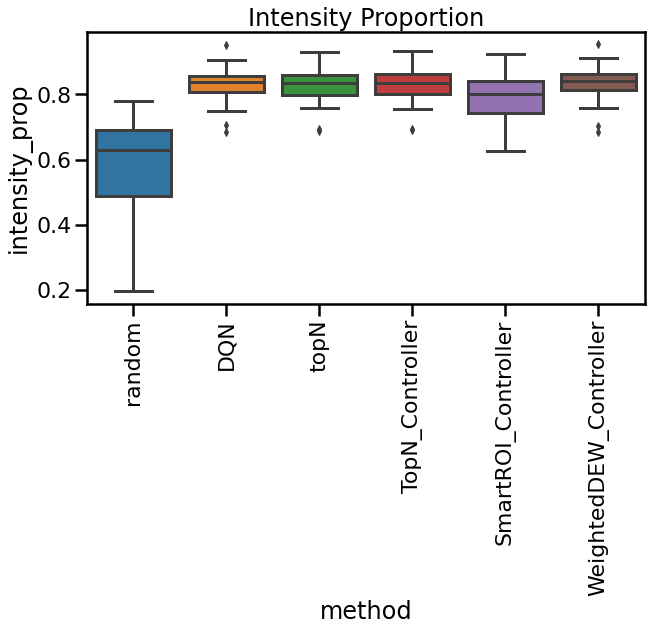

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='intensity_prop')
plt.xticks(rotation=90)
plt.title('Intensity Proportion')

Text(0.5, 1.0, 'MS1/MS2 Ratio')

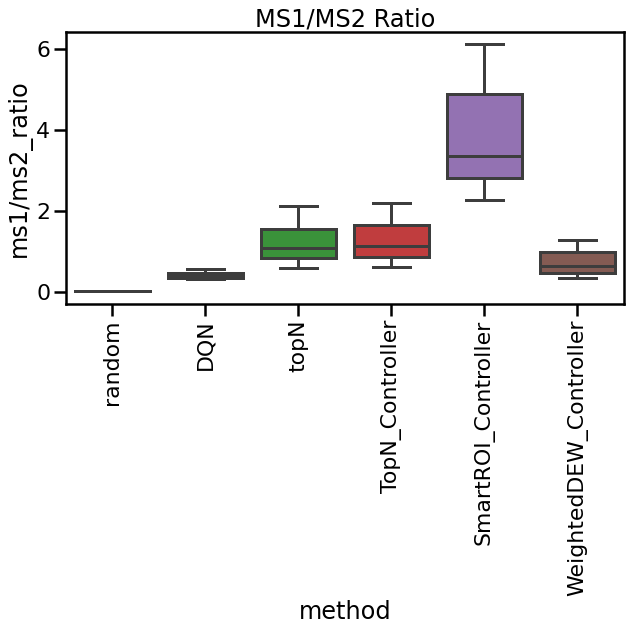

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='ms1/ms2_ratio')
plt.xticks(rotation=90)
plt.title('MS1/MS2 Ratio')

Text(0.5, 1.0, 'Efficiency')

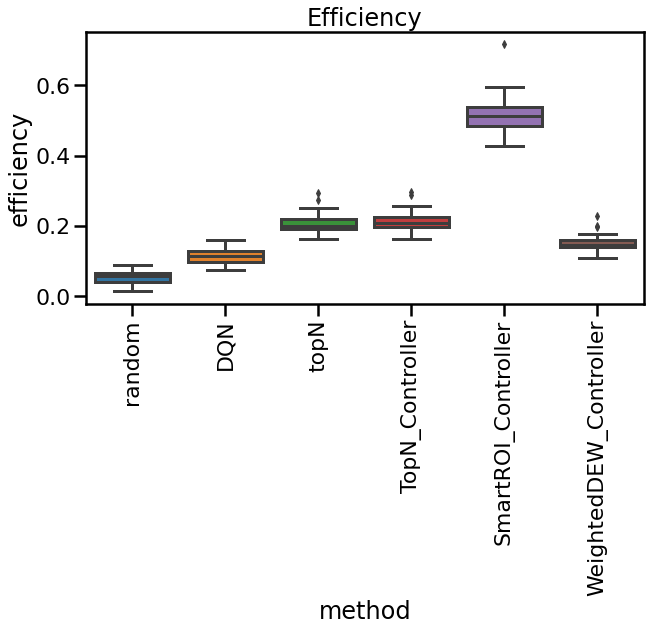

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='efficiency')
plt.xticks(rotation=90)
plt.title('Efficiency')

Text(0.5, 1.0, 'Precision')

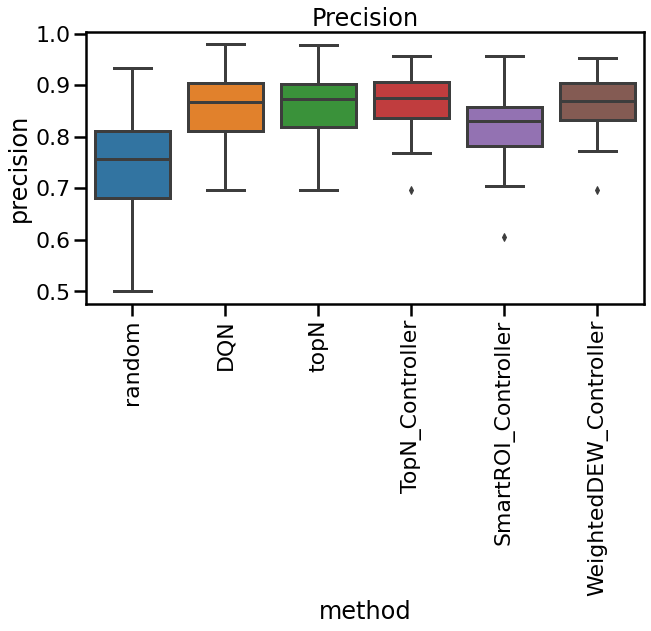

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='precision')
plt.xticks(rotation=90)
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

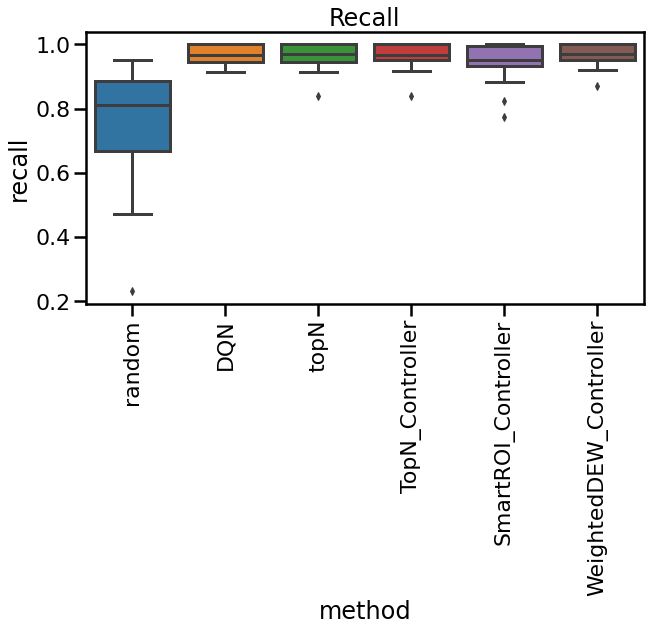

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='recall')
plt.xticks(rotation=90)
plt.title('Recall')

Text(0.5, 1.0, 'F1')

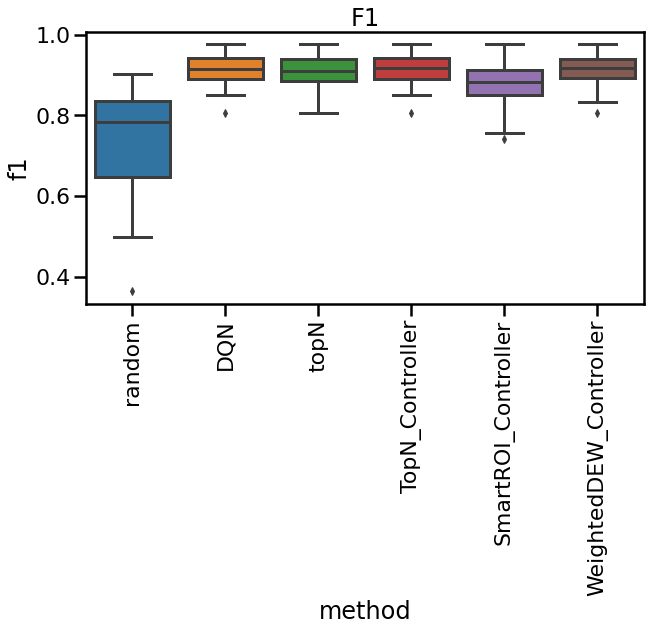

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='f1')
plt.xticks(rotation=90)
plt.title('F1')

In [ ]:
df.to_pickle('evaluation_5.0E6.p')

### Without 'random'

In [ ]:
df = pd.read_pickle('evaluation_5.0E6.p')

In [ ]:
new_df = df[df.method != 'random']
new_df.head()

,method,total_rewards,invalid_action_count,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
30,DQN,86.880941,0.0,0.929,0.848,0.361,0.089,0.923,0.923,0.923
31,DQN,79.071802,0.0,0.955,0.816,0.564,0.089,0.857,0.947,0.900
32,DQN,80.440152,4.0,0.933,0.829,0.445,0.158,0.905,0.927,0.916
33,DQN,91.549322,0.0,0.929,0.706,0.506,0.104,0.808,0.913,0.857
34,DQN,80.410661,0.0,1.000,0.816,0.438,0.075,0.800,1.000,0.889


Text(0.5, 1.0, 'Total Rewards')

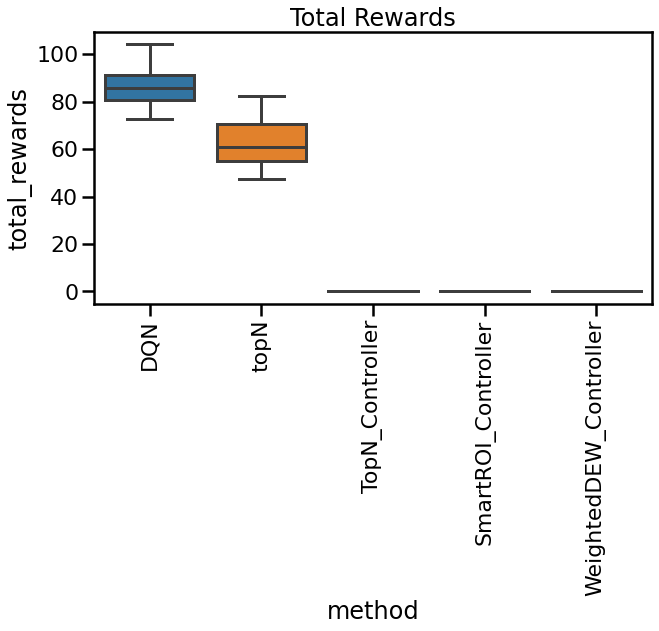

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='total_rewards', showfliers=False)
plt.xticks(rotation=90)
plt.title('Total Rewards')

Text(0.5, 1.0, 'Invalid Action Count')

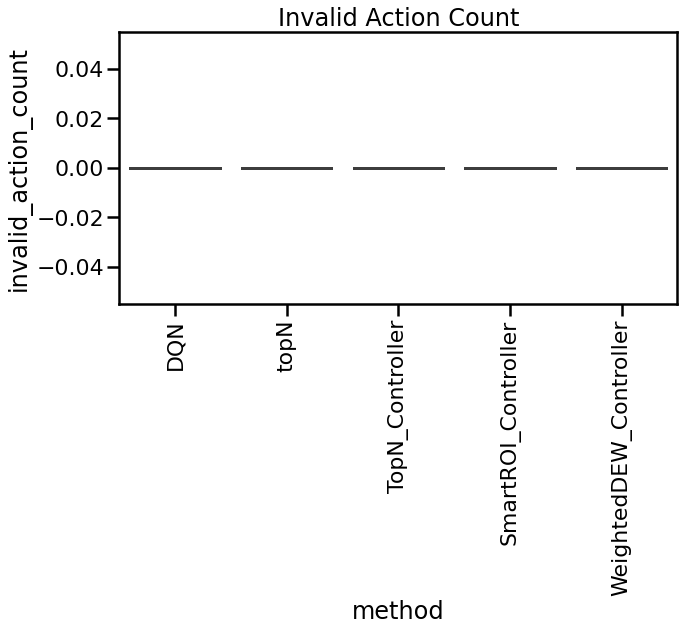

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='invalid_action_count', showfliers=False)
plt.xticks(rotation=90)
plt.title('Invalid Action Count')

Text(0.5, 1.0, 'Coverage Proportion')

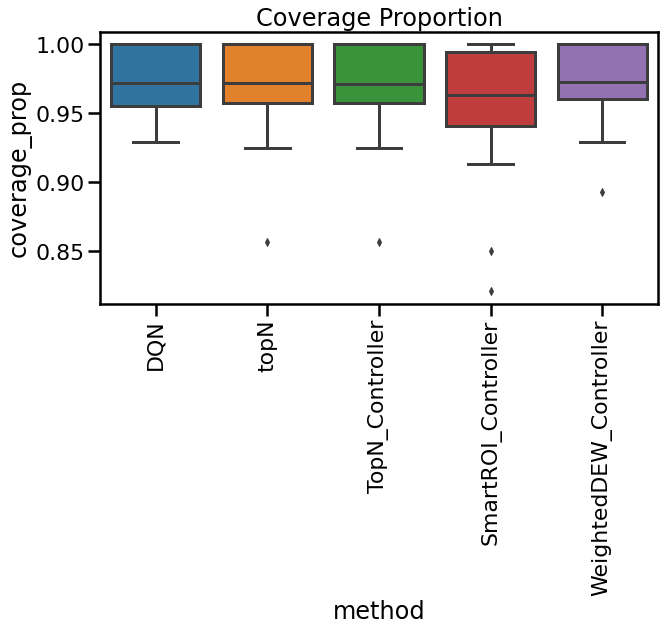

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='coverage_prop')
plt.xticks(rotation=90)
plt.title('Coverage Proportion')

Text(0.5, 1.0, 'Intensity Proportion')

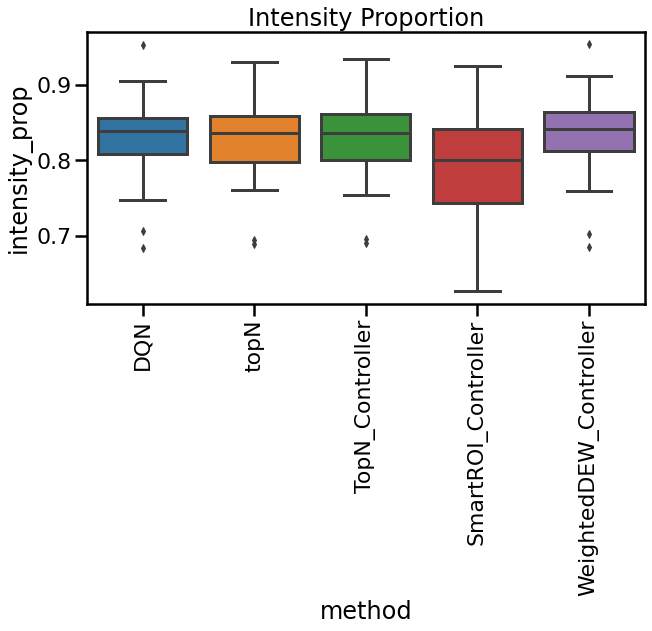

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='intensity_prop')
plt.xticks(rotation=90)
plt.title('Intensity Proportion')

Text(0.5, 1.0, 'MS1/MS2 Ratio')

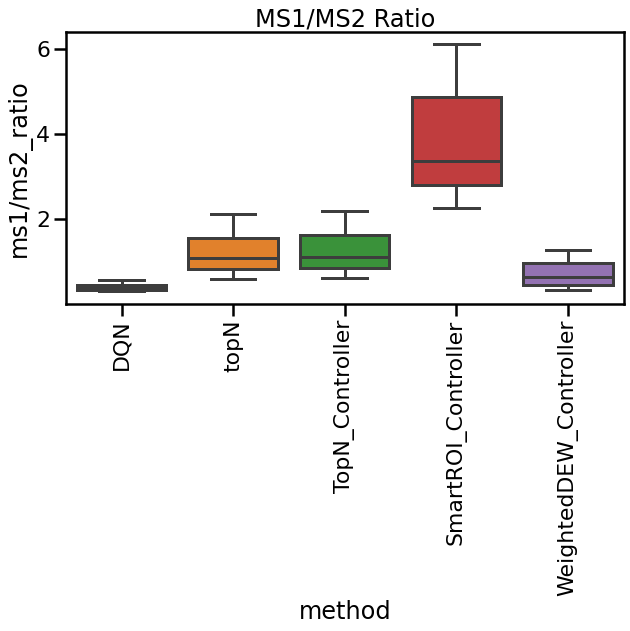

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='ms1/ms2_ratio')
plt.xticks(rotation=90)
plt.title('MS1/MS2 Ratio')

Text(0.5, 1.0, 'Precision')

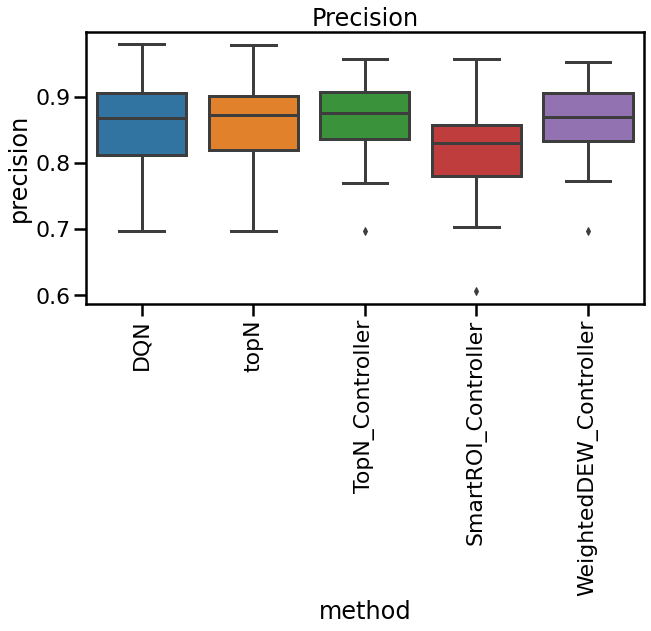

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='precision')
plt.xticks(rotation=90)
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

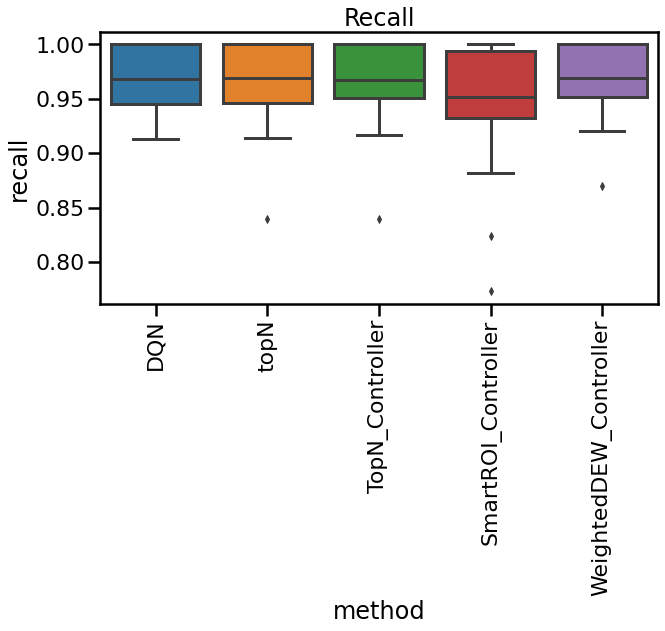

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='recall')
plt.xticks(rotation=90)
plt.title('Recall')

Text(0.5, 1.0, 'F1')

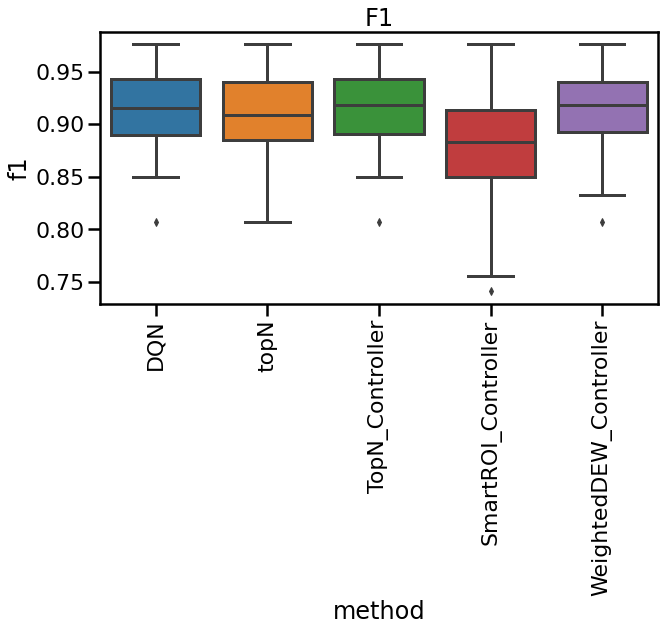

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='f1')
plt.xticks(rotation=90)
plt.title('F1')